# Predicting healthy and wilted houseplants

In [ ]:
# Importing libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import PIL
import os
import os.path
from PIL import Image
import numpy as np

In [9]:
# Code to resize all the images to 256*256
f = r'C:\Users\HP\HousePlants\Training\houseplant_images\healthy'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    rgb_im = img.convert("RGB")
    rgb_im = rgb_im.resize((256,256))
    rgb_im.save(f_img)

In [ ]:
# Code to resize all the images to 256*256
f = r'C:\Users\HP\HousePlants\Training\houseplant_images\wilted'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    rgb_im = img.convert("RGB")
    rgb_im = rgb_im.resize((256,256))
    rgb_im.save(f_img)

In [52]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [51]:
# Preprocessing dataset to the required image size and batch size

data = tf.keras.preprocessing.image_dataset_from_directory('houseplant_images', 
                                                    shuffle = True, 
                                                    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                    batch_size = BATCH_SIZE )

Found 904 files belonging to 2 classes.


In [14]:
# Class names of houseplants

class_names = data.class_names
class_names

['healthy', 'wilted']

In [15]:
# Length of the dataset which is divided into 32 batches

len(data)

29

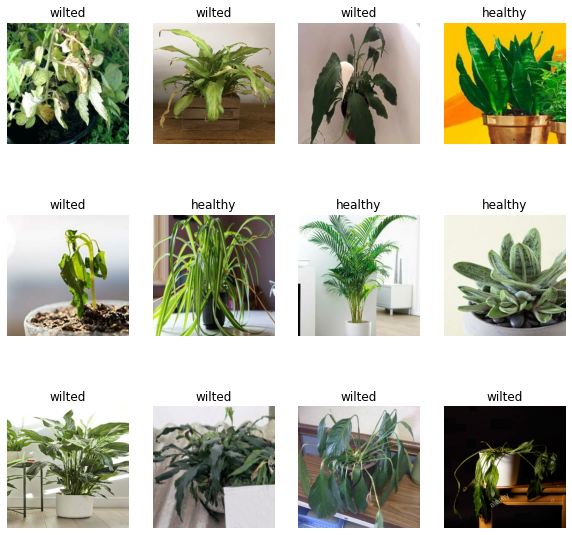

In [27]:
# Visualizing randomly selected 12 houseplant images with the labels

plt.figure(figsize = (10,10))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    

In [35]:
# 80% training, 10% validation and 10% test
# Split the dataset into train, validataion and test sets and store them in train, validation and test datasets respectively.

def get_data_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split *ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_data_partitions_tf(data)

In [41]:
# Shuffling and prefetching the datasets 

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [42]:
# Resizing and rescaling for preprocessing

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [45]:
# Data augmentation to consider flipped and rotated images 

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [46]:
# Model building

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [48]:
# Compilation

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [53]:
# Fitting the model

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
23/23 [==============================] - 414s 18s/step - loss: 0.7690 - accuracy: 0.5112 - val_loss: 0.7357 - val_accuracy: 0.4688
Epoch 2/20
23/23 [==============================] - 366s 16s/step - loss: 0.7070 - accuracy: 0.5000 - val_loss: 0.6820 - val_accuracy: 0.5312
Epoch 3/20
23/23 [==============================] - 381s 16s/step - loss: 0.6896 - accuracy: 0.5562 - val_loss: 0.6440 - val_accuracy: 0.7031
Epoch 4/20
23/23 [==============================] - 357s 15s/step - loss: 0.6422 - accuracy: 0.6531 - val_loss: 0.5435 - val_accuracy: 0.6875
Epoch 5/20
23/23 [==============================] - 356s 15s/step - loss: 0.6005 - accuracy: 0.6910 - val_loss: 0.5495 - val_accuracy: 0.6875
Epoch 6/20
23/23 [==============================] - 368s 16s/step - loss: 0.5922 - accuracy: 0.6798 - val_loss: 0.8405 - val_accuracy: 0.5781
Epoch 7/20
23/23 [==============================] - 424s 18s/step - loss: 0.6696 - accuracy: 0.6419 - val_loss: 0.5841 - val_accuracy: 0.7188
Epoch 

In [55]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 22s 3s/step - loss: 0.9042 - accuracy: 0.7788


In [56]:
scores

[0.9042309522628784, 0.7788461446762085]

In [57]:
history

In [58]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 23}

In [59]:
# Accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

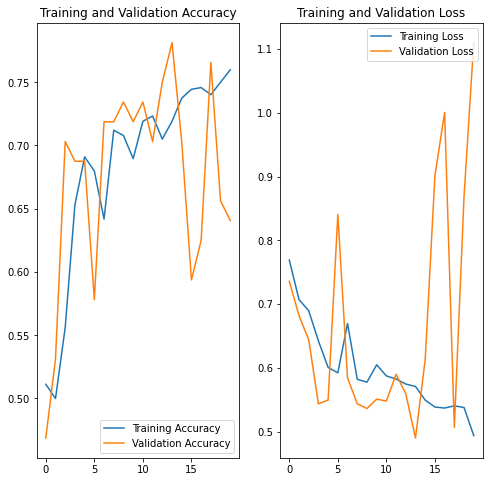

In [60]:
#Plots showing the accuracy and los for the range of epochs

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: healthy
1/1 [==============================] - 4s 4s/step
predicted label: healthy


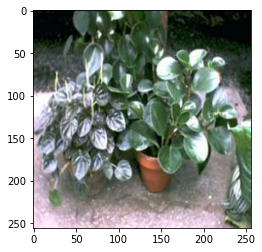

In [63]:
# Model prediction using the test set

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [64]:
# Defining a predict function to return predicted class and confidence for a batch of images

def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 139ms/step


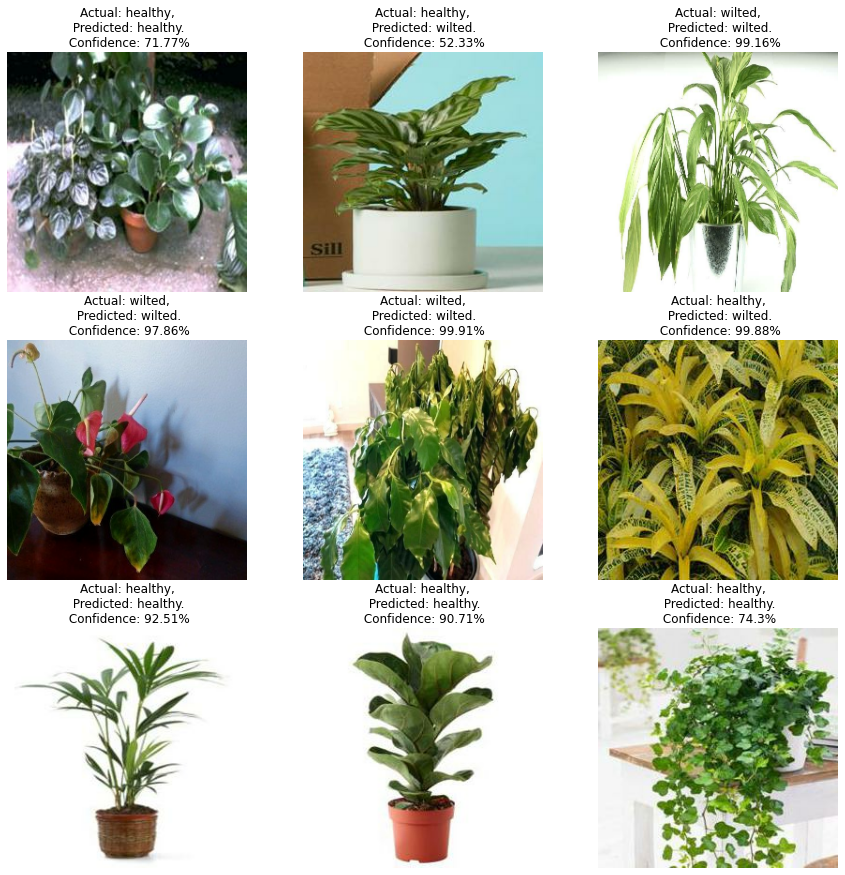

In [67]:
# Visualization showing the actual and predicted images from the testset along with confidence levels

plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%')
        plt.axis("off")

In [68]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
